In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from scsavailability import model as md, features as ft, plotting as pt

In [3]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'
av_raw = pd.read_csv(path + "Availability_for_ML.csv")
fa_nov = pd.read_csv(path + "SCS_Alerts_NOV.csv")
fa_oct = pd.read_csv(path + "SCS_Alerts_OCT.csv")

In [4]:
data = ft.pre_process_av_and_fa_oct_nov(av_raw,fa_oct,fa_nov,remove_same_location_faults = True)

fa = data['faults']
av = data['availability']

fa = ft.floor_time(fa,'Entry time',floor_units='H',shift = 10,shift_units='m') 

fa = ft.faults_aggregate_and_pivot(df=fa,
                                time_col='Entry time',
                                fault_level='Module',
                                agg_col='Duration',
                                agg_type='count',#can use mean/count/sum
                                quadrant=None,# by default all quadrants are kept
                                break_durations=False)

fa  = ft.weight_hours(df=fa, weights = [1,0.5])

av = ft.availability_quadrant_mean(df=av,
                                time_col='Datetime',
                                level = 'Quadrant', # by default all data is kept
                                selection = 1) 

df = ft.merge_av_fa(av_df=av,
                 fa_df=fa,
                 min_date=None, 
                 max_date=None) #specify min/max date if you want to filter data by date


#remove columns with only zeros (faults that did not happen in this period of time or quadrant)
df = df.loc[:, (df != 0).any(axis=0)]
df.head()

Quadrants Assigned
Modules Assigned
duplicated location faults removed - max duration kept
Fault and availability data pre-processed
Time shifted by 10m
Faults aggregated and pivoted
Previous Hours Weighted
Output will contain data only for Quadrant: 1
Availability data aggregated
Availability and fault datasets merged


,Datetime,Downtime,1,10,11,12,13,14,15,17,...,C07 External,C08 External,C09 External,C11 External,C12 External,C13 External,C14 External,Destacker,ECB,Outer Loop
0,2020-10-16 06:00:00,0.387239,6.0,4.50,2.75,16.0,3.0,3.0,8.0,6.0,...,8.0,23.0,7.5,6.0,1.0,13.0,4.5,20.5,36.0,31.5
1,2020-10-16 07:00:00,0.358683,7.5,5.00,8.00,13.0,3.0,1.5,8.5,4.0,...,6.5,25.0,10.5,3.0,2.0,12.0,9.5,17.0,16.5,45.5
2,2020-10-16 08:00:00,0.270361,10.0,3.75,7.25,28.5,2.0,0.0,6.5,4.0,...,5.5,35.5,9.0,5.5,7.0,14.0,8.0,11.0,10.0,53.5
3,2020-10-16 09:00:00,0.218726,22.5,4.00,7.25,22.0,1.5,2.0,10.0,10.5,...,5.5,23.0,6.5,2.5,12.0,18.0,5.0,18.0,11.0,62.5
4,2020-10-16 10:00:00,0.179861,18.5,4.50,5.75,19.0,2.5,1.0,10.0,9.5,...,10.0,12.0,11.0,5.0,12.5,22.5,9.5,9.5,17.5,52.5


Feature Importance Ranking: 
 
    Importance       Feature
0    0.190368             2
1    0.083534             7
2    0.051719           ECB
3    0.049122            20
4    0.039483             3
5    0.037857             8
6    0.036200            10
7    0.032764            12
8    0.032546             9
9    0.031493  C11 External

Regression Metrics: 
 
           RF Metrics
MAE         0.097047
MSE         0.013975
RMSE        0.118217
MAPE%      35.860000
ACC%       64.140000
OOB         0.343592
R2_Train    0.913423
R2_Pred     0.448842 


Number of Selected Features:15 

Feature Importance Ranking: 
 
    Importance       Feature
0    0.155403             2
1    0.078040           ECB
2    0.075869             7
3    0.067107             3
4    0.062052             9
5    0.061664            20
6    0.060032             8
7    0.059698  C11 External
8    0.058791            15
9    0.058408  C06 External

Regression Metrics: 
 
          D_Tree Metrics  RF Metrics
MAE      

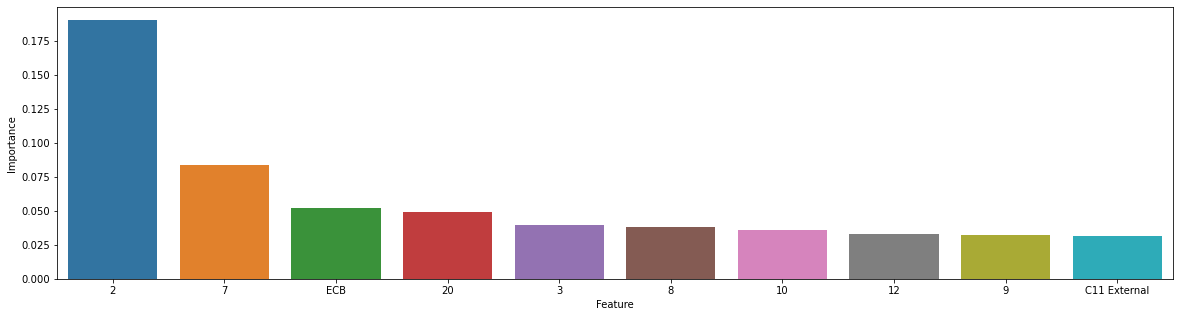

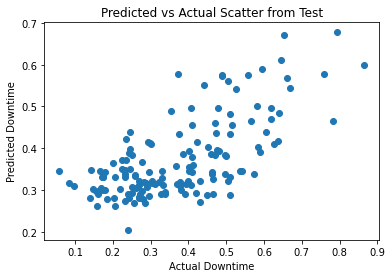

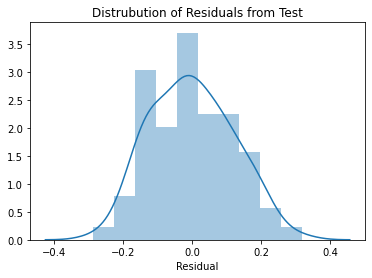

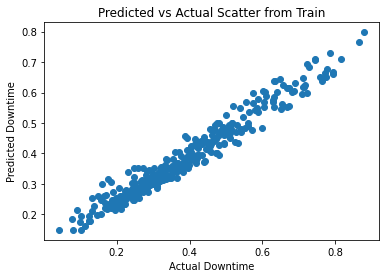

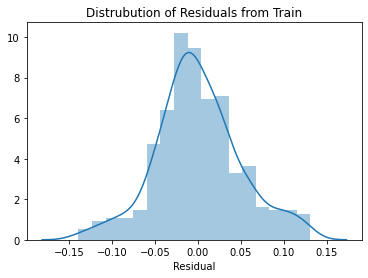

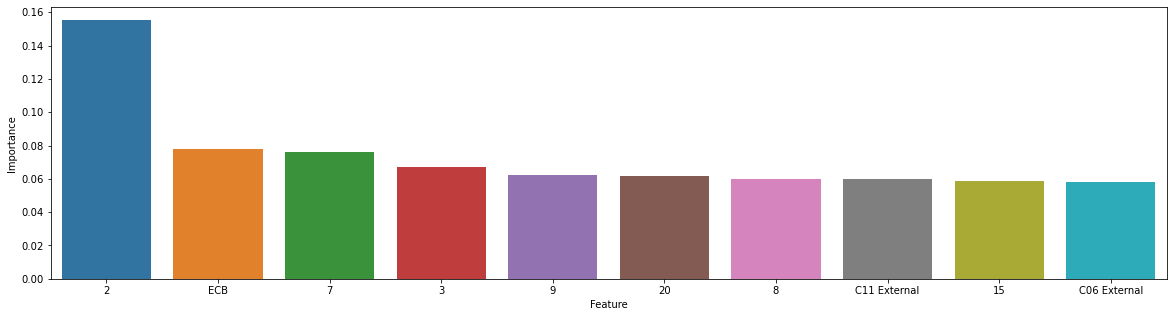

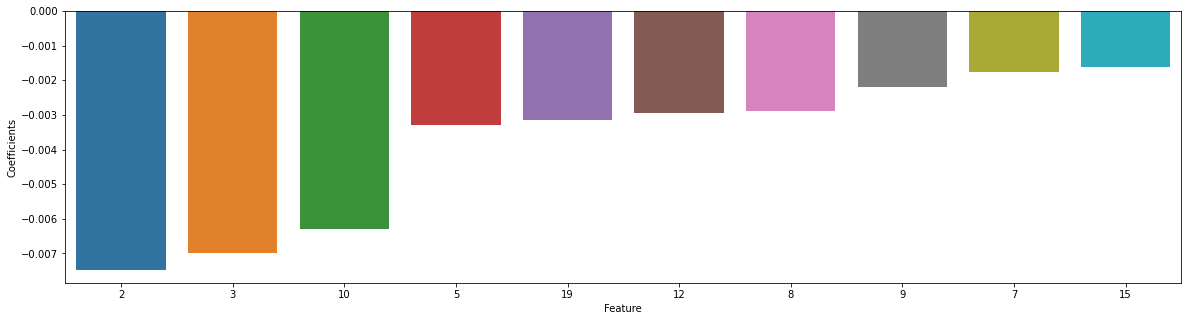

In [5]:
X, y = md.gen_feat_var(df)

X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=101)

RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

pt.plot_graphs(RF_mdl, X_train, y_train, y_test, predictions_RF)

X_sel=md.select_features(X, X_train, y_train, RF_mdl, thres = 'median')

X_train, X_test, y_train, y_test = md.split(X_sel, y ,test_size=0.3,random_state=101)

RF_mdl_sel,predictions_RF_sel=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mae', max_depth=100, dtree=True)

Linear_mdl,predictions_LM=md.run_LR_model(X_train, X_test, y_train, y_test)

cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)